In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def clean_value(value):
    return float(value.strip('[]'))

# Leer los datos desde el archivo CSV
data = pd.read_csv('alert_data.csv')

# Limpiar y transformar los datos
data['roll'] = data['roll'].apply(clean_value)
data['pitch'] = data['pitch'].apply(clean_value)
data['yaw'] = data['yaw'].apply(clean_value)

# Seleccionar las características (sin la columna de tiempo, ya que no es relevante para el autoencoder)
X = data[['ear', 'gaze', 'roll', 'pitch', 'yaw', 'tired', 'asleep', 'looking_away', 'distracted']].values

# Normalizar las características (es importante para redes neuronales)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers

# Definir la arquitectura del Autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 4  # El número de neuronas en la capa de codificación (dimensión reducida)

# Capa de entrada
input_layer = layers.Input(shape=(input_dim,))

# Capa de codificación
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)

# Capa de decodificación
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# Crear el modelo de Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Ver la arquitectura del Autoencoder
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 4)                 40        
                                                                 
 dense_1 (Dense)             (None, 9)                 45        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


In [3]:
# Entrenar el modelo
history = autoencoder.fit(X_scaled, X_scaled, 
                          epochs=100, 
                          batch_size=64, 
                          shuffle=True, 
                          validation_split=0.2)


Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.8583 - val_loss: 1.1319
Epoch 2/100
55/55 [==============================] - 0s 3ms/step - loss: 0.8221 - val_loss: 1.0849
Epoch 3/100
55/55 [==============================] - 0s 3ms/step - loss: 0.7859 - val_loss: 1.0281
Epoch 4/100
55/55 [==============================] - 0s 4ms/step - loss: 0.7446 - val_loss: 0.9575
Epoch 5/100
55/55 [==============================] - 0s 4ms/step - loss: 0.6987 - val_loss: 0.8864
Epoch 6/100
55/55 [==============================] - 0s 4ms/step - loss: 0.6553 - val_loss: 0.8233
Epoch 7/100
55/55 [==============================] - 0s 4ms/step - loss: 0.6187 - val_loss: 0.7723
Epoch 8/100
55/55 [==============================] - 0s 4ms/step - loss: 0.5892 - val_loss: 0.7339
Epoch 9/100
55/55 [==============================] - 0s 3ms/step - loss: 0.5656 - val_loss: 0.7048
Epoch 10/100
55/55 [==============================] - 0s 3ms/step - loss: 0.5460 - val_loss: 0.6837
Epoch 11/

In [4]:
# Obtener las reconstrucciones
reconstrucciones = autoencoder.predict(X_scaled)

# Calcular el error de reconstrucción (MSE)
mse = np.mean(np.power(X_scaled - reconstrucciones, 2), axis=1)

# Establecer un umbral para identificar anomalías
umbral = np.percentile(mse, 95)  # Elige el percentil del 95% como umbral

# Etiquetar las instancias que superan el umbral como anomalías
anomalies = mse > umbral

# Añadir las etiquetas de anomalía al dataframe original
data['anomaly'] = anomalies

# Filtrar los casos que son anomalías (posibles situaciones de riesgo)
situaciones_riesgo = data[data['anomaly'] == True]
print(situaciones_riesgo)


137/137 [==============================] - 0s 2ms/step
          timestamp       ear      gaze  roll  pitch   yaw  tired  asleep  \
41    170531.479680  0.281556  0.006214  1.77   7.85 -2.99      0       0   
42    170531.510427  0.289898  0.006979  1.53   7.60 -2.96      0       0   
44    170531.573102  0.306432  0.008260  1.46   7.50 -2.22      0       0   
45    170531.604535  0.316623  0.009008  1.46   7.20 -2.16      0       0   
46    170531.635728  0.271736  0.008564  1.12   6.58 -1.71      0       0   
...             ...       ...       ...   ...    ...   ...    ...     ...   
4364  170675.575754  0.241423  0.005909  0.34   6.67 -3.72      0       0   
4365  170675.607178  0.254034  0.006375  0.78   6.68 -2.71      0       0   
4366  170675.637865  0.251957  0.006219  0.73   7.09 -2.69      0       0   
4367  170675.669503  0.260520  0.007245  0.82   6.86 -2.82      0       0   
4368  170675.699657  0.246365  0.007992  0.93   7.00 -2.55      0       0   

      looking_away  

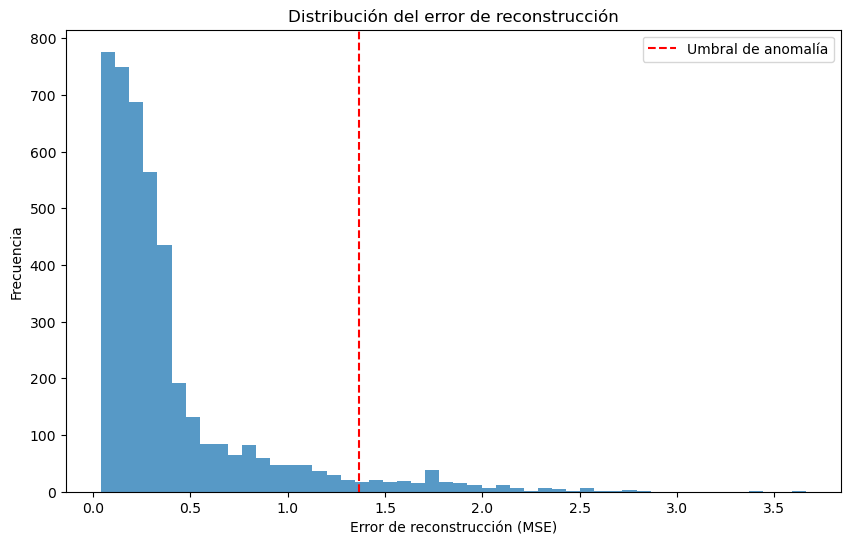

Número de situaciones de riesgo detectadas: 219
Número total de situaciones: 4369
umbral: 1.3684132220383802
error máximo: 3.6603956374922766


In [5]:
import matplotlib.pyplot as plt

# Graficar el error de reconstrucción
plt.figure(figsize=(10,6))
plt.hist(mse, bins=50, alpha=0.75)
plt.axvline(umbral, color='red', linestyle='--', label='Umbral de anomalía')
plt.title('Distribución del error de reconstrucción')
plt.xlabel('Error de reconstrucción (MSE)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

print('Número de situaciones de riesgo detectadas:', len(situaciones_riesgo))
print('Número total de situaciones:', len(data))
print('umbral:', umbral)
print('error máximo:', max(mse))

In [6]:
import numpy as np

# Definir el umbral de anomalía (ya identificado en tu gráfico)
umbral_anomalia = umbral

# Error máximo observado en el dataset (puedes ajustar esto de acuerdo a tu gráfico)
error_maximo = max(mse)

# Función para calcular el porcentaje de probabilidad de accidente
def calcular_probabilidad_riesgo(error_reconstruccion, umbral=umbral_anomalia, max_error=error_maximo):
    if error_reconstruccion <= umbral:
        return 0.0  # No es un riesgo si el error está por debajo del umbral
    else:
        return min(1.0, (error_reconstruccion - umbral) / (max_error - umbral)) * 100  # Escalamos a porcentaje

# Ejemplo de uso con un array de errores de reconstrucción
errores_reconstruccion = [0.2, 0.5, 1.0, 1.7, 2.5, 3.0]
probabilidades_riesgo = [calcular_probabilidad_riesgo(error) for error in errores_reconstruccion]

print(probabilidades_riesgo)


[0.0, 0.0, 0.0, 14.467247904079292, 49.37152965623972, 71.18670575133999]


In [7]:
autoencoder.save('autoencoder_model.h5')

OSError: [Errno 0] Unable to synchronously create file (unable to lock file, errno = 0, error message = 'No error', Win32 GetLastError() = 33)